In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import classification_models
from classification_models import GetLoader

In [2]:
#导入训练数据
a=np.load("new_train_data.npy")
b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
c=b[~np.isnan(b).any(axis=1),:]
train_data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
d=np.load("new_train_label.npy").reshape(-1,1)
train_label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)

In [3]:
#导入valid数据
a=np.load("new_valid_data.npy")
b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
c=b[~np.isnan(b).any(axis=1),:]
valid_data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
d=np.load("new_valid_label.npy").reshape(-1,1)
valid_label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)

In [4]:
def predict_precision(model,images,labels,device,predict_type):
    with torch.no_grad():
        correct=0
        total=0
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=sum(predicted)
        correct+=(sum(predicted*labels))
        print('precision of the model on the'+predict_type+'data: {}%'.format(100*correct/total))
    return predicted, 100*correct/total

In [5]:
#TRIAL1
#from classification_models import ResNet1D_LSTM
#from classification_models import BasicBlock

In [7]:
# 搭建ResNet-LSTM Model (Many-to-One) 相较于简单的cnn-lstm，resnet可以防止梯度消失
#搭建第一类ResNet block
class BasicBlock(nn.Module):#基本残差网络的一个模块类
    expansion = 1#每一个residual block中不改变width,height,channel数，即增加的residual部分不需要做卷积处理

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)#stride=1,kernel_size=3,padding=1保证了data的
                                                                                   #size不变 
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.LeakyReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:  #BasicBlock内不需要调整residual的height,width,channel
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

#组建block成ResNet
class ResNet1D_LSTM(nn.Module):
    def __init__(self, block, blocks_num, num_classes, feature_channel,hidden_size, num_layers,device ):
        super(ResNet1D_LSTM, self).__init__()
        self.in_channel = 64
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.conv1 = nn.Conv1d(in_channels=feature_channel, out_channels=self.in_channel, kernel_size=2, stride=2,
                               padding=0, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_channel)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  #channel数变为n/2(非整数时向下取整)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])         #按照已有结论按二次方形式增长ResNet不同阶段的channel
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2表示想把上一个layer传过来的size缩减为1/2
        self.avgpool = nn.AdaptiveAvgPool1d((1, 1))  # output size = (1, 1) 
        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) #预处理
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) #残差网络
        x = self.layer2(x)
        
        x=torch.transpose(x,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [8]:
# Hyper Parameters
sequence_length = 8  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 128  # 隐藏层的size
num_layers =  2 # 有多少层

num_classes = 2
batch_size = 512
num_epochs = 1000
learning_rate = 0.001

device = torch.device("cuda:1")

In [9]:
resnet_lstm=ResNet1D_LSTM(BasicBlock, [2,3], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
resnet_lstm.to(device)

ResNet1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(2,), stride=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.

In [10]:
train_data=np.transpose(train_data,(0,2,1))
valid_data=np.transpose(valid_data,(0,2,1))
train=GetLoader(train_data,train_label)
valid=GetLoader(valid_data,valid_label)
train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_data.shape[0],shuffle=False,num_workers=0)

In [11]:
train_data.shape

(397353, 42, 10)

In [12]:
total_step=0
train_precision=[]
valid_precision=[]

In [13]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_lstm.parameters(), lr=learning_rate)

In [14]:
#训练
total_step=0
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=resnet_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(resnet_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

Epoch [2/1000],step[1000] Loss:0.6850
precision of the model on thetrainingdata: nan%
precision of the model on thevalidationdata: nan%
Epoch [3/1000],step[2000] Loss:0.6870
precision of the model on thetrainingdata: nan%
precision of the model on thevalidationdata: nan%
Epoch [4/1000],step[3000] Loss:0.6930
precision of the model on thetrainingdata: 54.54545593261719%
precision of the model on thevalidationdata: 54.45134735107422%
Epoch [6/1000],step[4000] Loss:0.6918
precision of the model on thetrainingdata: 35.71428680419922%
precision of the model on thevalidationdata: 54.21686935424805%
Epoch [7/1000],step[5000] Loss:0.6940
precision of the model on thetrainingdata: 52.94117736816406%
precision of the model on thevalidationdata: 47.123661041259766%
Epoch [8/1000],step[6000] Loss:0.6891
precision of the model on thetrainingdata: 58.730159759521484%
precision of the model on thevalidationdata: 52.16731262207031%
Epoch [10/1000],step[7000] Loss:0.6894
precision of the model on thetr

KeyboardInterrupt: 

Text(0, 0.5, 'precision')

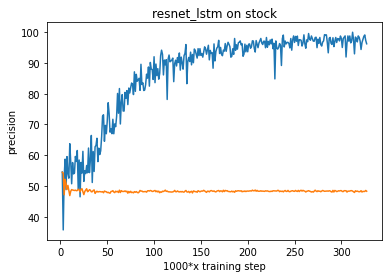

In [15]:
#pic5
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("resnet_lstm on stock")
plt.xlabel("1000*x training step")
plt.ylabel("precision")

trial 1


$Hyper Parameters
sequence_length = 8  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 512  # 隐藏层的size
num_layers =  2 # 有多少层
num_classes = 2
batch_size = 1024
num_epochs = 1000
learning_rate = 0.01
device = torch.device("cuda:1")$

由于整体层数比较多，参数也多，导致可能出现了梯度消失的情况（pic5）。

下一步将层数、参数、batch_size缩减做进一步尝试:

trial2

$Hyper Parameters
sequence_length = 8  # 序列长度，将图像的每一列作为一个序列
feature_channel=42
hidden_size = 128  # 隐藏层的size
num_layers =  2 # 有多少层
num_classes = 2
batch_size = 512
num_epochs = 1000
learning_rate = 0.001
device = torch.device("cuda:1")
激活函数换为leakyrelu$

解决了梯度消失的问题，但是预测还是无效